# Predicting Listing Gains in the Indian IPO Market

## Table of Contents
 * [Introduction](#introduction)
 * [Goal](#goal)
 * [Summary](#summary)
 * [The Data](#the_data)
   * [Data Preprocessing](#data_preprocessing)
     * [Stripping Whitespaces](#stripping_whitespaces)
     * [Creating a Categorical Target Variable](#categorical_target)
     * [Exploring the Date Column](#exploring_the_date_column)
     * [Choosing features for the Model](#choosing_features)
   * [Data Visualization](#data_visulization)
   * [Outlier Treatment](#outlier_treatment)
 * [Creating the Holdout Validation Approach](#holdout_validation)
 * [Define the Deep Learning Classification Model](#define_classification_model)
     * [Retraining the model](#retraining_the_model)
   * [Choosing the Best Model](#choosing_the_best_model)
 * [Conclusion](#conclusion)


## Introduction  <a name="introduction"></a>

This research explores the application of deep learning techniques to predict listing gains in the Indian Initial Public Offering (IPO) market. Listing gains—defined as the percentage increase in a company's share price from its IPO issue price on the listing day—represent a significant opportunity for investors.\
As the lead data scientist at our investment firm, I was tasked with developing a classification model to identify promising IPO opportunities by predicting the likelihood of positive listing gains.

## Goal  <a name="goal"></a>

To develop a neural network-based classification model that predicts IPO listing gains with a target accuracy threshold of 80%, enabling data-driven investment decisions in the Indian IPO market.

## Summary  <a name="summary"></a>

The developed neural network achieved a 71% prediction accuracy on the test dataset for IPO listing gains.\
While this performance demonstrates the model's potential for supporting investment decisions, there remains significant room for improvement to reach the target accuracy of 80%.

## The Data <a name="the_data"></a>

The dataset I'll be using for the project comes from [moneycontrol](https://www.moneycontrol.com/ipo/ipo-historic-table?classic=true), a leading business & finance portal that's focused on the Asia markets. It contains information on past IPOs in the Indian market.

The following is some boilerplate code that loads the required libraries, reads the data and displays some initial information about it:

In [51]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
#from scipy import stats
import keras_tuner
import random

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import set_global_policy

from sklearn.model_selection import train_test_split


plt.style.use('seaborn-v0_8')

# Don't enforce line width for outputs
pd.set_option('display.width', None)

# Suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Enable mixed precision to improve performance
set_global_policy('mixed_float16')

In [52]:
# Reading the file
data = pd.read_csv("Indian_IPO_Market_Data.csv")

In [53]:
data.shape

(319, 9)

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   319 non-null    object 
 1   IPOName                319 non-null    object 
 2   Issue_Size             319 non-null    float64
 3   Subscription_QIB       319 non-null    float64
 4   Subscription_HNI       319 non-null    float64
 5   Subscription_RII       319 non-null    float64
 6   Subscription_Total     319 non-null    float64
 7   Issue_Price            319 non-null    int64  
 8   Listing_Gains_Percent  319 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 22.6+ KB


In [55]:
data.head()

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
0,03/02/10,Infinite Comp,189.800,48.440,106.020,11.080,43.220,165,11.820
1,08/02/10,Jubilant Food,328.700,59.390,51.950,3.790,31.110,145,-84.210
2,15/02/10,Syncom Health,56.250,0.990,16.600,6.250,5.170,75,17.130
3,15/02/10,Vascon Engineer,199.800,1.120,3.650,0.620,1.220,165,-11.280
4,19/02/10,Thangamayil,0.000,0.520,1.520,2.260,1.120,75,-5.200


In [56]:
data.tail()

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
314,26/08/22,Syrma SGS,840.130,42.420,7.130,2.840,15.590,220,42.300
315,06/09/22,Dreamfolks Serv,562.100,27.480,14.180,24.190,23.250,326,41.920
316,15/09/22,TMB,792.000,0.510,1.770,3.440,1.390,525,-3.150
317,26/09/22,Harsha Engineer,755.000,113.820,40.360,12.440,47.190,330,47.240
318,17/10/22,Electronics Mar,500.000,58.810,15.390,8.270,24.230,59,43.140


In [57]:
data.describe()

,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
count,319.000,319.000,319.000,319.000,319.000,319.000,319.000
mean,1192.860,25.684,70.091,8.562,27.447,375.129,4.743
std,2384.644,40.717,142.454,14.509,48.772,353.898,47.651
min,0.000,0.000,0.000,0.000,0.000,0.000,-97.150
25%,169.005,1.150,1.255,1.275,1.645,119.000,-11.555
50%,496.250,4.940,5.070,3.420,4.930,250.000,1.810
75%,1100.000,34.635,62.095,8.605,33.395,536.000,25.310
max,21000.000,215.450,958.070,119.440,326.490,2150.000,270.400


The dataset has 319 observations, each with 9 features.

There are no missing values in any of the features.

The features are as follows:

| Variable Name         | Role    | Type    | Description                                                                    | Units                 |
| --------------------- | ------- | ------- | ------------------------------------------------------------------------------ | --------------------- |
| Date                  | Feature | string  | Date when the IPO was listed                                                   |                       |
| IPOName               | Feature | string  | Name of the IPO                                                                |                       |
| Issue_Size            | Feature | float   | size of the IPO issue                                                          | INR Crores ($10^7$ ₹) |
| Subscription_QIB      | Feature | float   | Subscription rate of the QIB (Qualified Institutional Buyer) investor category |                       |
| Subscription_HNI      | Feature | float   | Subscription rate of the HNI (High Networth Individual) investor category      |                       |
| Subscription_RII      | Feature | float   | Subscription rate of the RII (Retail Individual Investors) investor category   |                       |
| Subscription_Total    | Feature | float   | Weighted average of the IPO's subscription rate                                |                       |
| Issue_Price           | Feature | integer | the price at which the IPO was issued                                          | ₹                     |
| Listing_Gains_Percent | Target  | float   | The percentage gain in the listing price over the issue price                  | %                     |

### Data Preprocessing <a name="data_preprocessing"></a>

#### Stripping Whitespaces <a name="stripping_whitespaces"></a>

Some of the column names have whitespaces in them, which makes accessing them difficult. Let's remove them.

In [58]:
data = data.rename(columns=lambda x: x.strip())
data.columns

Index(['Date', 'IPOName', 'Issue_Size', 'Subscription_QIB', 'Subscription_HNI',
       'Subscription_RII', 'Subscription_Total', 'Issue_Price',
       'Listing_Gains_Percent'],
      dtype='object')

#### Creating a Categorical Target Variable <a name="categorical_target"></a>

In this project I'll build a classification model. To build such a model I need to have a categorical target, but the target variable I have (`Listing_Gains_Percent`) is continuous.\
The simplest way to convert it into a categorical variable is by creating a binary variable which will be `1` when `Listing_Gains_Percent` is positive and 0 otherwise, so that's what I'll do:

In [59]:
data['Listing_Gains_Profit'] = data['Listing_Gains_Percent'].apply(lambda x: 1 if x > 0 else 0)

In [60]:
data['Listing_Gains_Profit'].value_counts(normalize=True).round(2)

Listing_Gains_Profit
1   0.550
0   0.450
Name: proportion, dtype: float64

About 55% of the IPOs in the database are listed in profit. So while there's a small tendency for IPOs to list profit, the data in general is quite balanced.

#### Exploring the Date Column <a name="exploring_the_date_column"></a>

I want to check if there are trends in the target column across the year. To do that I'll extract the month and day data from the `Date` column and aggregate.

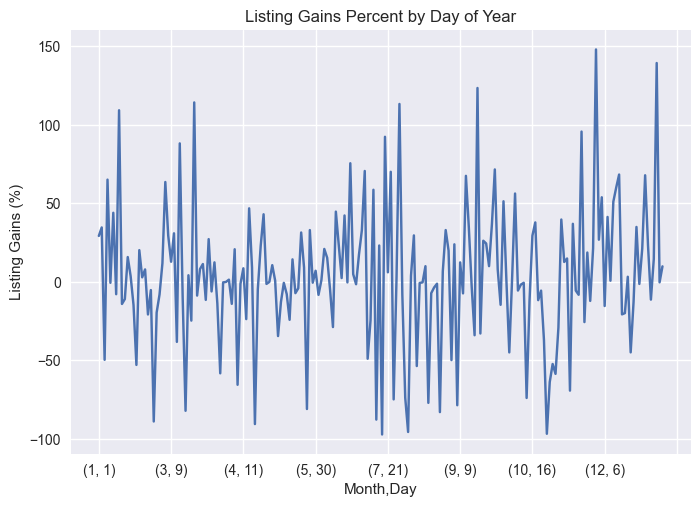

In [61]:
# First, turn the date in datetime format
data['Formatted_Date'] = pd.to_datetime(data['Date'], format="%d/%m/%y")

# Now we can easily extract the required information
data['Month'] = data['Formatted_Date'].dt.month
data['Day'] = data['Formatted_Date'].dt.day

# Group by month and day, then get the mean value of the 'Listing_Gains_Percent'
gains_by_date = data.groupby(['Month', 'Day'])['Listing_Gains_Percent'].mean()

# Plot the grouped data
gains_by_date.plot()
plt.title("Listing Gains Percent by Day of Year")
plt.ylabel("Listing Gains (%)")
plt.show()

This is a very erratic data. that doesn't show any clear pattern. I think it's best not ot use it in the model moving forward.

#### Choosing features for the Model <a name="choosing_features"></a>

Aside for the date data, the name doesn't have any predictive value as well. I'll also remove `Listgin_Gains_Percent`, since I've created a target colum based on its data.

That leaves us with 6 features that potentially have predictive power, and that's a good number to build a model with.

In [62]:
data.drop(['Date', 'Formatted_Date', 'Month', 'Day', 'IPOName', 'Listing_Gains_Percent'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Issue_Size            319 non-null    float64
 1   Subscription_QIB      319 non-null    float64
 2   Subscription_HNI      319 non-null    float64
 3   Subscription_RII      319 non-null    float64
 4   Subscription_Total    319 non-null    float64
 5   Issue_Price           319 non-null    int64  
 6   Listing_Gains_Profit  319 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 17.6 KB


### Data Visualization <a name="data_visulization"></a>

Some visualizations of the data, to better understand it:

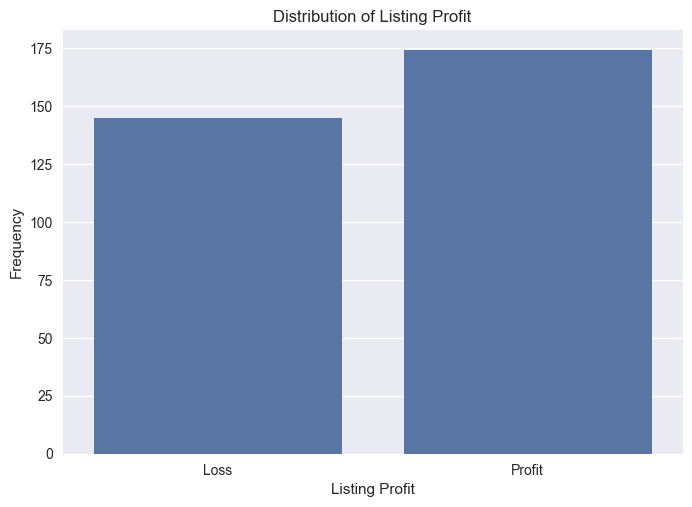

In [63]:
sns.countplot(data=data, x='Listing_Gains_Profit').set(xticks=[0, 1], xticklabels=['Loss' ,'Profit'])
plt.title("Distribution of Listing Profit")
plt.xlabel("Listing Profit")
plt.ylabel("Frequency")           
plt.show()

In [64]:
def explore_features_skewness(df, features):
    plt.figure(figsize=(15, 10))
    
    # Create subplots for each variable
    fig, axes = plt.subplots(6, 2, figsize=(20, 28))

    # Create histograms and box plots for each variable
    for idx, column in enumerate(features):
        # Histogram with KDE
        sns.histplot(data=df, x=column, kde=True, ax=axes[idx, 0])
        axes[idx, 0].set_title(f'Histogram of {column.replace("_", " ")}')
        
        # Box plot
        sns.boxplot(data=df, y=column, ax=axes[idx, 1])
        axes[idx, 1].set_title(f'Box Plot of {column.replace("_", " ")}')
    
    # Adjust layout
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # Calculate and display summary statistics with percentiles
    print("\nSummary Statistics with Percentiles:")
    display(df[features].describe(percentiles=[.05, .25, .50, .75, .95]).round(2))
    
    print("\nMode(s) of each feature:")
    # Show the mode for each variable
    display(df[features].mode())
    
    # Calculate skewness for each variable
    print("\nSkewness of each variable:")
    display(df[features].skew().round(2))

<Figure size 1500x1000 with 0 Axes>

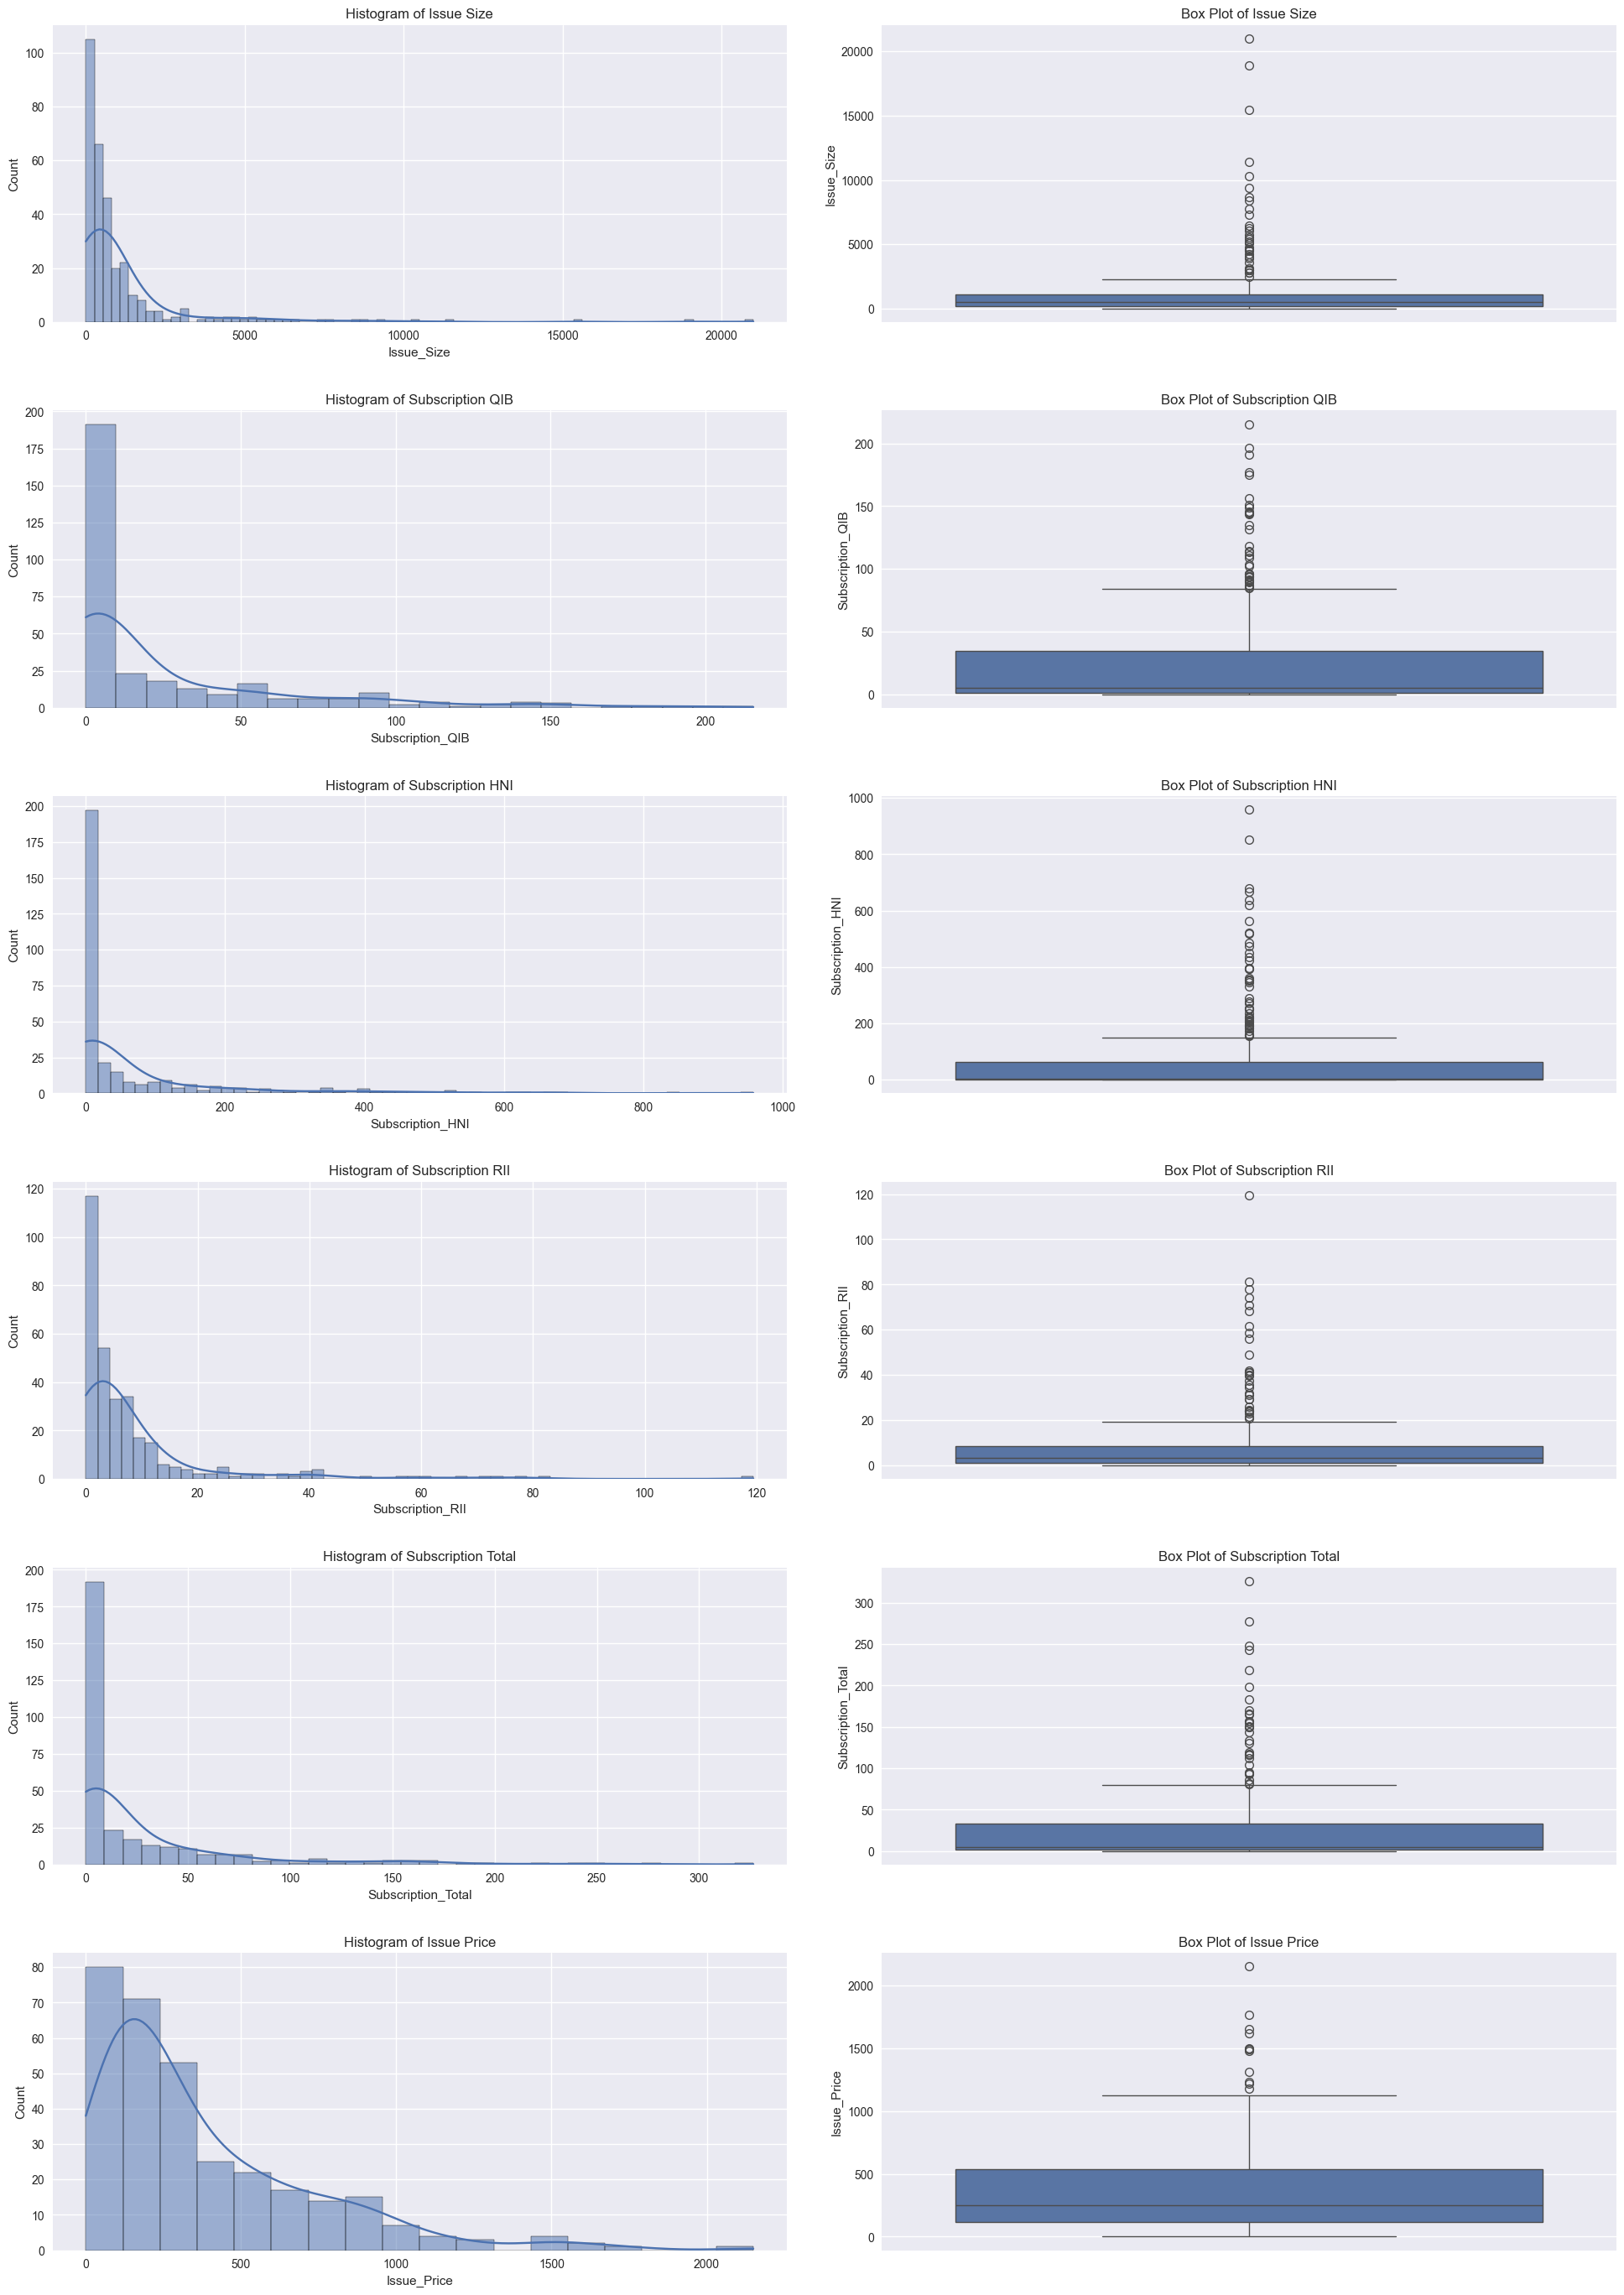


Summary Statistics with Percentiles:


,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price
count,319.000,319.000,319.000,319.000,319.000,319.000
mean,1192.860,25.680,70.090,8.560,27.450,375.130
std,2384.640,40.720,142.450,14.510,48.770,353.900
min,0.000,0.000,0.000,0.000,0.000,0.000
5%,44.810,0.000,0.100,0.240,0.740,42.700
25%,169.000,1.150,1.250,1.270,1.640,119.000
50%,496.250,4.940,5.070,3.420,4.930,250.000
75%,1100.000,34.640,62.100,8.600,33.390,536.000
95%,5249.000,113.570,392.300,39.580,144.520,1034.700
max,21000.000,215.450,958.070,119.440,326.490,2150.000



Mode(s) of each feature:


,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price
0,600.000,0.000,0.000,0.000,0.000,75
1,NaN,NaN,0.220,NaN,NaN,110
2,NaN,NaN,NaN,NaN,NaN,175



Skewness of each variable:


Issue_Size           4.850
Subscription_QIB     2.140
Subscription_HNI     3.080
Subscription_RII     3.710
Subscription_Total   2.910
Issue_Price          1.700
dtype: float64

In [65]:
# List of columns to plot
feature_names = data.drop('Listing_Gains_Profit', axis=1).columns

explore_features_skewness(data, feature_names)

All the features show a similar pattern of a significant positive skew, with a mode at 0 (or near it, relative to the other values) and a long tail following it.\
Let's look for correlations between the variables.

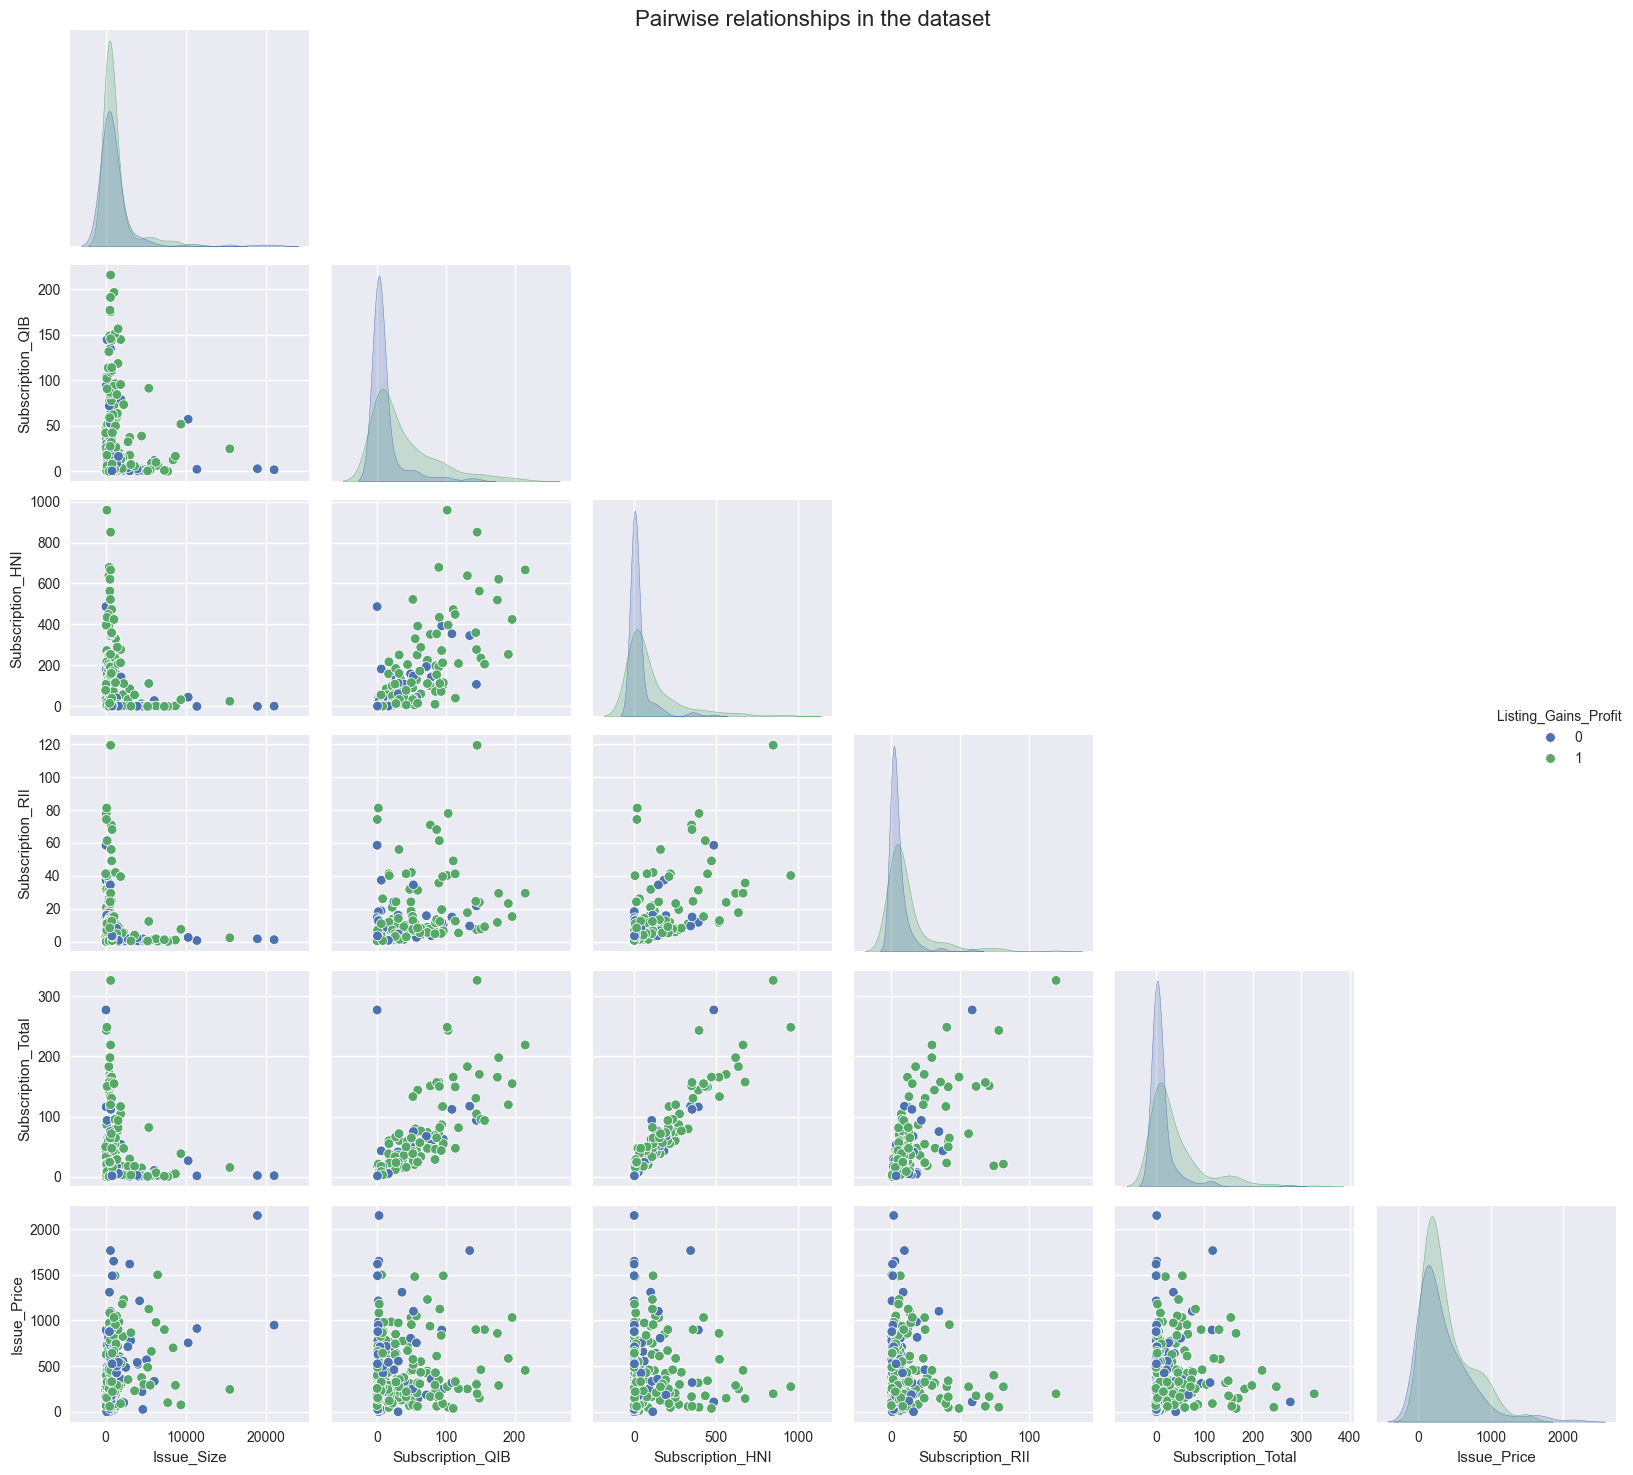

In [66]:
sns.pairplot(data, hue="Listing_Gains_Profit", corner=True)
plt.suptitle("Pairwise relationships in the dataset", fontsize=16)

plt.tight_layout()
plt.show()

`Subscription_Total` is correlated with the other subscription indices, which is expected since this variable is a weighted average of all of them.
Segmenting by the listing gains doesn't generate distinct groups when comparing variables, however, we can see that in each of the subscription indices, the variance is higher for the "profit" (1) group relative to the "loss" (0) group, which indicates that they'll be good predictors for this variable.\
Let's check the statistics of each feature, when segmented by the values of the target variable:

In [67]:
def plot_feature_distributions(data, features):
    """
    Create split violin plots showing the distribution of features segmented by IPO listing gains.
    
    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame containing the features and target variable ('Listing_Gains_Profit')
    features : list
        List of feature column names to plot
        
    Returns
    -------
    None
        Displays the violin plots using matplotlib
        
    Notes
    -----
    - Creates horizontal subplots for each feature
    - Shows split violin plots with loss/profit distributions
    - Includes legend only on the first plot to reduce clutter
    - Shows y-label only on the first plot
    """
    fig, axes = plt.subplots(1, len(features), figsize=(25, 6))
    axes = axes.flatten()
    
    for idx, feature in enumerate(features):
        # Create split violin plot
        p = sns.violinplot(data=data, y=feature, hue='Listing_Gains_Profit', 
                          split=True, inner='quartile', ax=axes[idx])
        
        # Customize the plot
        axes[idx].set_title(f'Distribution of {feature.replace("_", " ")}', pad=20)
        axes[idx].set_ylabel('')
        # Only keep the legend of the first plot, to reduce clutter
        if idx:
            axes[idx].legend('')
    
    # Set legend for the first plot
    handles, _ = axes[0].get_legend_handles_labels()
    axes[0].legend(handles=handles, labels=['Loss', 'Profit'], 
                  loc='upper left', title='Listing Gains')
    
    # Only show the y label on the first plot, to reduce clutter
    axes[0].set_ylabel('Loss vs Profit')
    plt.tight_layout()
    plt.show()

In [68]:
def create_statistics_table(data, features):
    """
    Create a comprehensive statistics table comparing feature distributions between profit and loss groups.
    
    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame containing the features and target variable ('Listing_Gains_Profit')
    features : list
        List of feature column names to analyze
        
    Returns
    -------
    pandas.DataFrame
        A multi-index DataFrame containing statistics for each feature:
        - Mean, Median, Std for both groups and their relative differences
        - Skewness for both groups and their absolute difference
        - Mann-Whitney U test p-values
        
    Notes
    -----
    - Uses a hierarchical index for statistics and their components
    - Shows relative differences as percentages for Mean, Median, and Std
    - Shows absolute difference for Skewness
    - Includes Mann-Whitney U test p-values for statistical significance
    """
    # Create statistics dictionary
    stats_dict = {}
    for feature in features:
        loss_stats = data[data['Listing_Gains_Profit'] == 0][feature]
        profit_stats = data[data['Listing_Gains_Profit'] == 1][feature]
        
        # Calculate statistics
        feature_stats = {
            ('Mean', 'Loss'): loss_stats.mean(),
            ('Mean', 'Profit'): profit_stats.mean(),
            ('Mean', 'Rel diff (%)'): ((profit_stats.mean() / loss_stats.mean()) - 1) * 100,
            
            ('Median', 'Loss'): loss_stats.median(),
            ('Median', 'Profit'): profit_stats.median(),
            ('Median', 'Rel diff (%)'): ((profit_stats.median() / loss_stats.median()) - 1) * 100,
            
            ('Std', 'Loss'): loss_stats.std(),
            ('Std', 'Profit'): profit_stats.std(),
            ('Std', 'Rel diff (%)'): ((profit_stats.std() / loss_stats.std()) - 1) * 100,
            
            ('Skewness', 'Loss'): loss_stats.skew(),
            ('Skewness', 'Profit'): profit_stats.skew(),
            ('Skewness', 'Diff'): (profit_stats.skew() - loss_stats.skew()),
            
            ('P-Value', ''): stats.mannwhitneyu(loss_stats, profit_stats, 
                                              alternative='two-sided').pvalue
        }
        
        stats_dict[feature.replace('_', ' ')] = feature_stats
    
    # Create MultiIndex
    index = []
    for stat in ['Mean', 'Median', 'Std']:
        index.extend([(stat, 'Loss'), (stat, 'Profit'), (stat, 'Rel diff (%)')])
    index.extend([('Skewness', 'Loss'), ('Skewness', 'Profit'), ('Skewness', 'Diff')])
    index.append(('P-Value', ''))
    
    # Create and return DataFrame with MultiIndex
    df = pd.DataFrame(stats_dict, index=pd.MultiIndex.from_tuples(index))
    
    return df

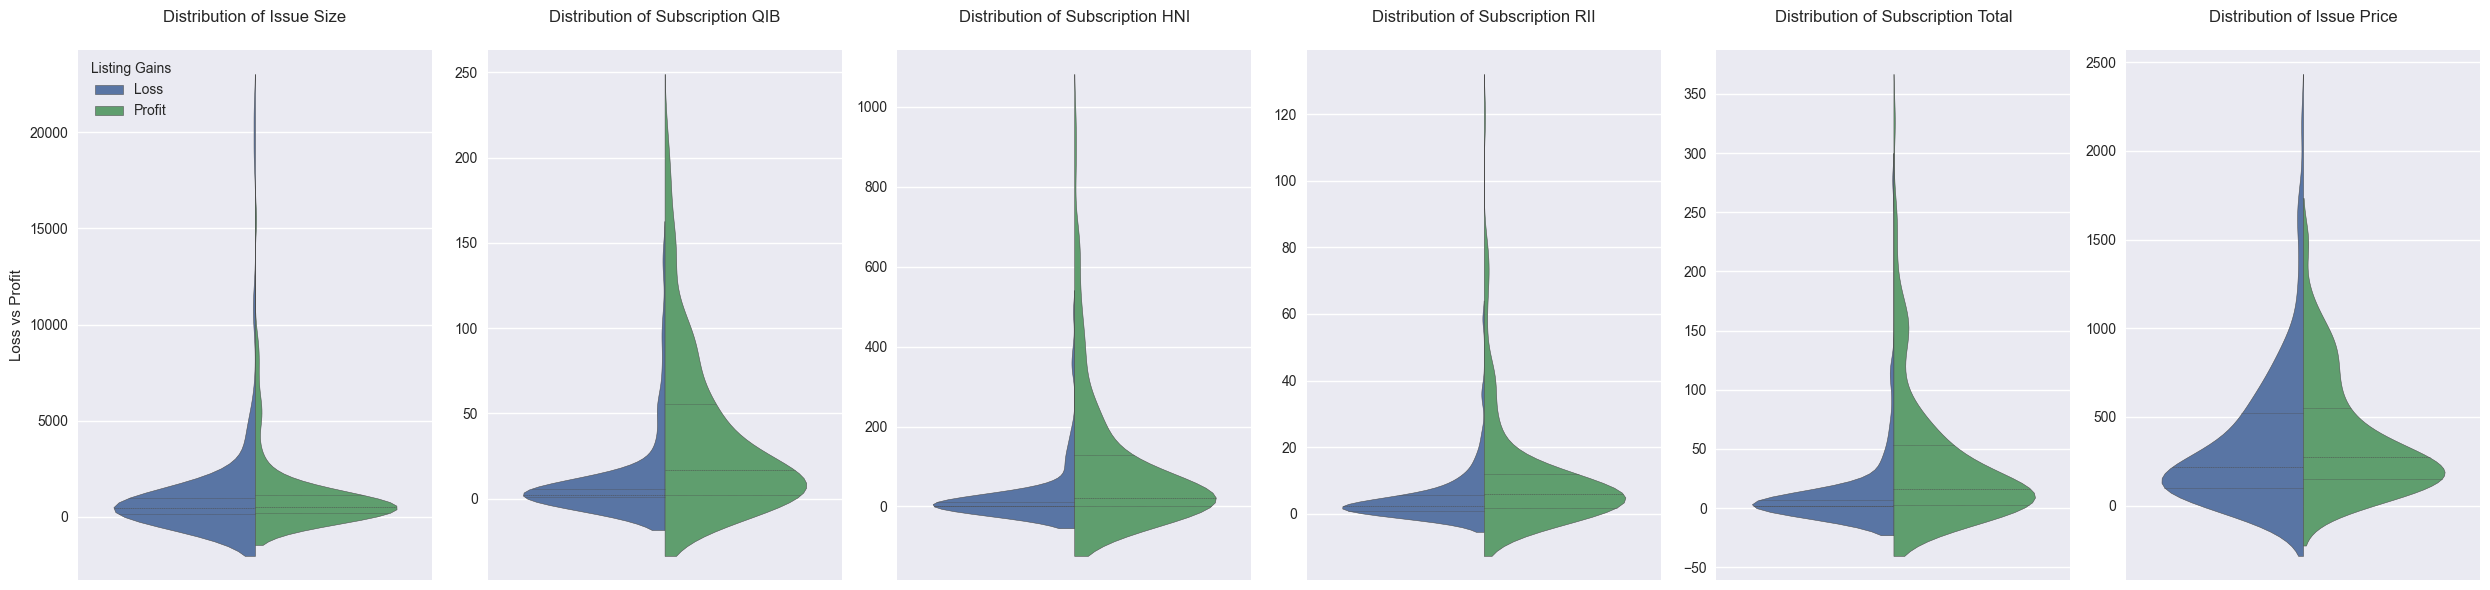


Unified Statistics Table:


Issue Size  Subscription QIB  Subscription HNI  \
Mean     Loss            1180.559            11.278            27.731   
         Profit          1203.111            37.689           105.392   
         Rel diff (%)       1.910           234.194           280.052   
Median   Loss             450.000             1.960             2.090   
         Profit           540.260            16.845            21.970   
         Rel diff (%)      20.058           759.439           951.196   
Std      Loss            2743.000            24.833            73.281   
         Profit          2046.867            47.066           173.421   
         Rel diff (%)     -25.379            89.527           136.651   
Skewness Loss               5.268             3.357             4.095   
         Profit             3.665             1.604             2.393   
         Diff              -1.604            -1.753            -1.702   
P-Value                     0.084             0.000             0.000   

                       Subscription RII  Subscription Total  Issue Price  
Mean     Loss                     4.740              12.333      359.821  
         Profit                  11.746              40.042      387.885  
         Rel diff (%)           147.826             224.682        7.800  
Median   Loss                     2.320               2.060      220.000  
         Profit                   6.035              16.395      272.000  
         Rel diff (%)           160.129             695.874       23.636  
Std      Loss                     7.440              31.005      382.578  
         Profit                  17.844              56.756      328.673  
         Rel diff (%)           139.842              83.053      -14.090  
Skewness Loss                     4.064               5.450        2.045  
         Profit                   2.994               2.209        1.277  
         Diff                    -1.071              -3.242       -0.768  
P-Value                           0.000               0.000        0.060

In [69]:
plot_feature_distributions(data, feature_names)
stats_df = create_statistics_table(data, feature_names)

print("\nUnified Statistics Table:")
print("="*107)
display(stats_df)

Key Insights:

* Subscription rates, particularly from institutional and high-net-worth investors, are the strongest predictors of IPO success
* Issue size and price show a marginal statistical significance with IPO success, meaning they have weaker relationships with it
* All features show higher medians for profitable IPOs
* The data is heavily right-skewed for most features, suggesting the presence of some extremely oversubscribed IPOs

### Outlier Treatment <a name="outlier_treatment"></a>

I want to reduce the skewness of the data, so I'll look for outliers I can remove or handle some other way.

In [70]:
def count_outliers(data, features):
    """
    Count outliers in each feature based on the IQR method.
    
    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame containing the features
    features : list
        List of feature names to analyze
        
    Returns
    -------
    pandas.DataFrame
        A DataFrame containing outlier counts and percentages for each feature,
        split by profit/loss groups
    """
    outlier_stats = []
    
    for feature in features:
        # Calculate for entire feature
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        total_outliers = data[
            (data[feature] < lower_bound) | 
            (data[feature] > upper_bound)
        ].shape[0]
        
        # Calculate for loss group (0)
        loss_data = data[data['Listing_Gains_Profit'] == 0][feature]
        loss_outliers = loss_data[
            (loss_data < lower_bound) | 
            (loss_data > upper_bound)
        ].shape[0]
        
        # Calculate for profit group (1)
        profit_data = data[data['Listing_Gains_Profit'] == 1][feature]
        profit_outliers = profit_data[
            (profit_data < lower_bound) | 
            (profit_data > upper_bound)
        ].shape[0]
        
        # Calculate percentages
        total_pct = (total_outliers / len(data)) * 100
        loss_pct = (loss_outliers / len(loss_data)) * 100
        profit_pct = (profit_outliers / len(profit_data)) * 100
        
        outlier_stats.append({
            'Feature': feature.replace('_', ' '),
            'Total Outliers': total_outliers,
            'Total %': total_pct,
            'Loss Outliers': loss_outliers,
            'Loss %': loss_pct,
            'Profit Outliers': profit_outliers,
            'Profit %': profit_pct
        })
    
    # Create DataFrame and format it
    df = pd.DataFrame(outlier_stats)
    
    # Format percentages
    for col in ['Total %', 'Loss %', 'Profit %']:
        df[col] = df[col].round(1).astype(str) + '%'
        
    return df

In [71]:
# Calculate and display the results
outlier_df = count_outliers(data, feature_names)
display(outlier_df)

,Feature,Total Outliers,Total %,Loss Outliers,Loss %,Profit Outliers,Profit %
0,Issue Size,34,10.7%,15,10.3%,19,10.9%
1,Subscription QIB,35,11.0%,5,3.4%,30,17.2%
2,Subscription HNI,48,15.0%,7,4.8%,41,23.6%
3,Subscription RII,33,10.3%,5,3.4%,28,16.1%
4,Subscription Total,31,9.7%,5,3.4%,26,14.9%
5,Issue Price,12,3.8%,7,4.8%,5,2.9%


Looking at the table above, I don't think it's advisable to remove or clip the outliers, for several reasons:
* The outliers seem to be a significant percentage of the data, so due to the moderate sample size (`319`) removing them would potentially introduce unwanted bias
* There's a clear pattern in the distribution of outliers between profit/loss groups, which suggests that high subscription rates are predictive of IPO success
* The high subscription rates are meaningful business events, not data errors, so they hold important information about the market's behaviour

Instead of removal I'll perform log transformation on the features to reduce their skewness. Log-transforming the data also has the additional benefit of scaling it.

In [72]:
log_feature_names = [f'log_{feature}' for feature in feature_names]

for feature, log_feature in zip(feature_names, log_feature_names):
    data[log_feature] = np.log(data[feature] + 0.1)

<Figure size 1500x1000 with 0 Axes>

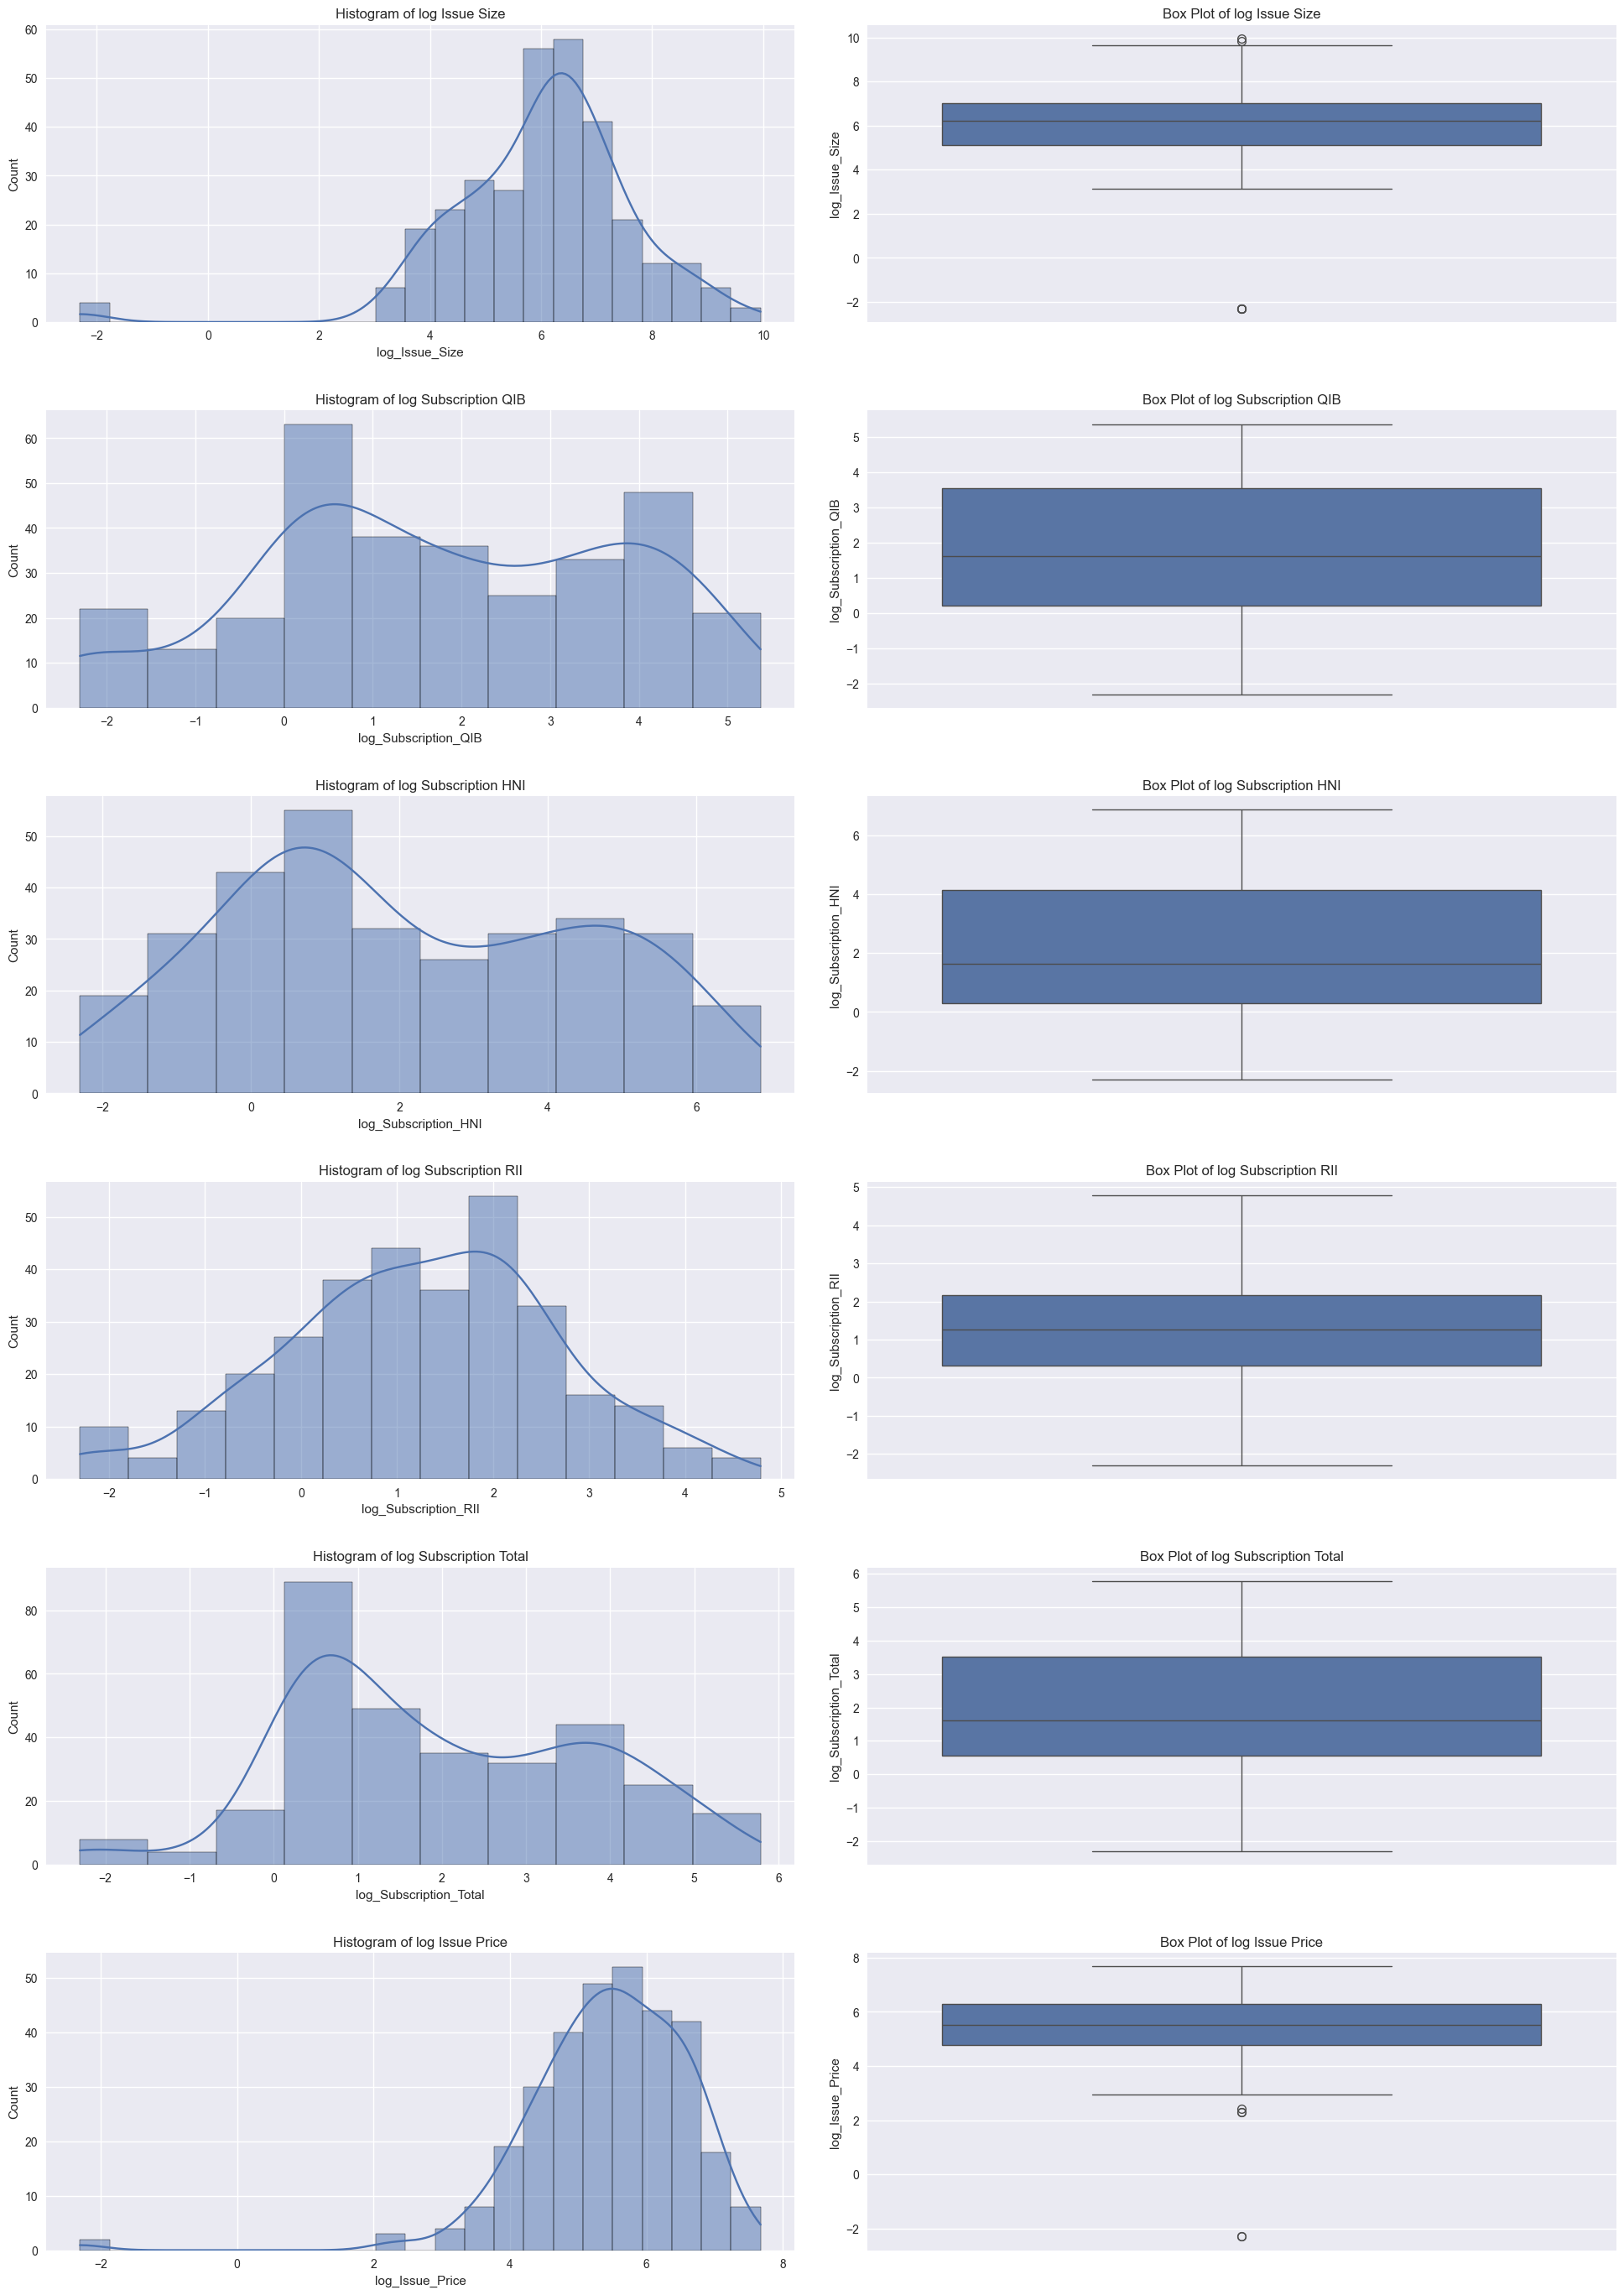


Summary Statistics with Percentiles:


,log_Issue_Size,log_Subscription_QIB,log_Subscription_HNI,log_Subscription_RII,log_Subscription_Total,log_Issue_Price
count,319.000,319.000,319.000,319.000,319.000,319.000
mean,6.030,1.730,2.070,1.240,1.950,5.440
std,1.660,2.030,2.390,1.440,1.760,1.180
min,-2.300,-2.300,-2.300,-2.300,-2.300,-2.300
5%,3.800,-2.300,-1.610,-1.080,-0.170,3.760
25%,5.130,0.220,0.300,0.320,0.560,4.780
50%,6.210,1.620,1.640,1.260,1.620,5.520
75%,7.000,3.550,4.130,2.160,3.510,6.280
95%,8.570,4.730,5.970,3.680,4.970,6.940
max,9.950,5.370,6.870,4.780,5.790,7.670



Mode(s) of each feature:


,log_Issue_Size,log_Subscription_QIB,log_Subscription_HNI,log_Subscription_RII,log_Subscription_Total,log_Issue_Price
0,6.397,-2.303,-2.303,-2.303,-2.303,4.319
1,NaN,NaN,-1.139,NaN,NaN,4.701
2,NaN,NaN,NaN,NaN,NaN,5.165



Skewness of each variable:


log_Issue_Size           -1.410
log_Subscription_QIB     -0.150
log_Subscription_HNI      0.140
log_Subscription_RII     -0.190
log_Subscription_Total    0.130
log_Issue_Price          -1.920
dtype: float64

In [73]:
explore_features_skewness(data, log_feature_names)

That's a significantly less skewed dataset, compared to the non-log-transformed data. Let's count the outliers: 

In [74]:
count_outliers(data, log_feature_names)

,Feature,Total Outliers,Total %,Loss Outliers,Loss %,Profit Outliers,Profit %
0,log Issue Size,6,1.9%,4,2.8%,2,1.1%
1,log Subscription QIB,0,0.0%,0,0.0%,0,0.0%
2,log Subscription HNI,0,0.0%,0,0.0%,0,0.0%
3,log Subscription RII,0,0.0%,0,0.0%,0,0.0%
4,log Subscription Total,0,0.0%,0,0.0%,0,0.0%
5,log Issue Price,5,1.6%,3,2.1%,2,1.1%


The log subscription indices don't have any outliers, and the other 2 features have a small number of outliers, which I can safely remove.

In [75]:
for feature in ['log_Issue_Price', 'log_Issue_Size']:
        # Calculate for entire feature
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[feature] < upper_bound) & (data[feature] > lower_bound)]

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 309 entries, 0 to 318
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Issue_Size              309 non-null    float64
 1   Subscription_QIB        309 non-null    float64
 2   Subscription_HNI        309 non-null    float64
 3   Subscription_RII        309 non-null    float64
 4   Subscription_Total      309 non-null    float64
 5   Issue_Price             309 non-null    int64  
 6   Listing_Gains_Profit    309 non-null    int64  
 7   log_Issue_Size          309 non-null    float64
 8   log_Subscription_QIB    309 non-null    float64
 9   log_Subscription_HNI    309 non-null    float64
 10  log_Subscription_RII    309 non-null    float64
 11  log_Subscription_Total  309 non-null    float64
 12  log_Issue_Price         309 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 33.8 KB


10 datapoints were removed as outliers, and now the data should be more symmetric across all features.\
Let's take another look at it:

<Figure size 1500x1000 with 0 Axes>

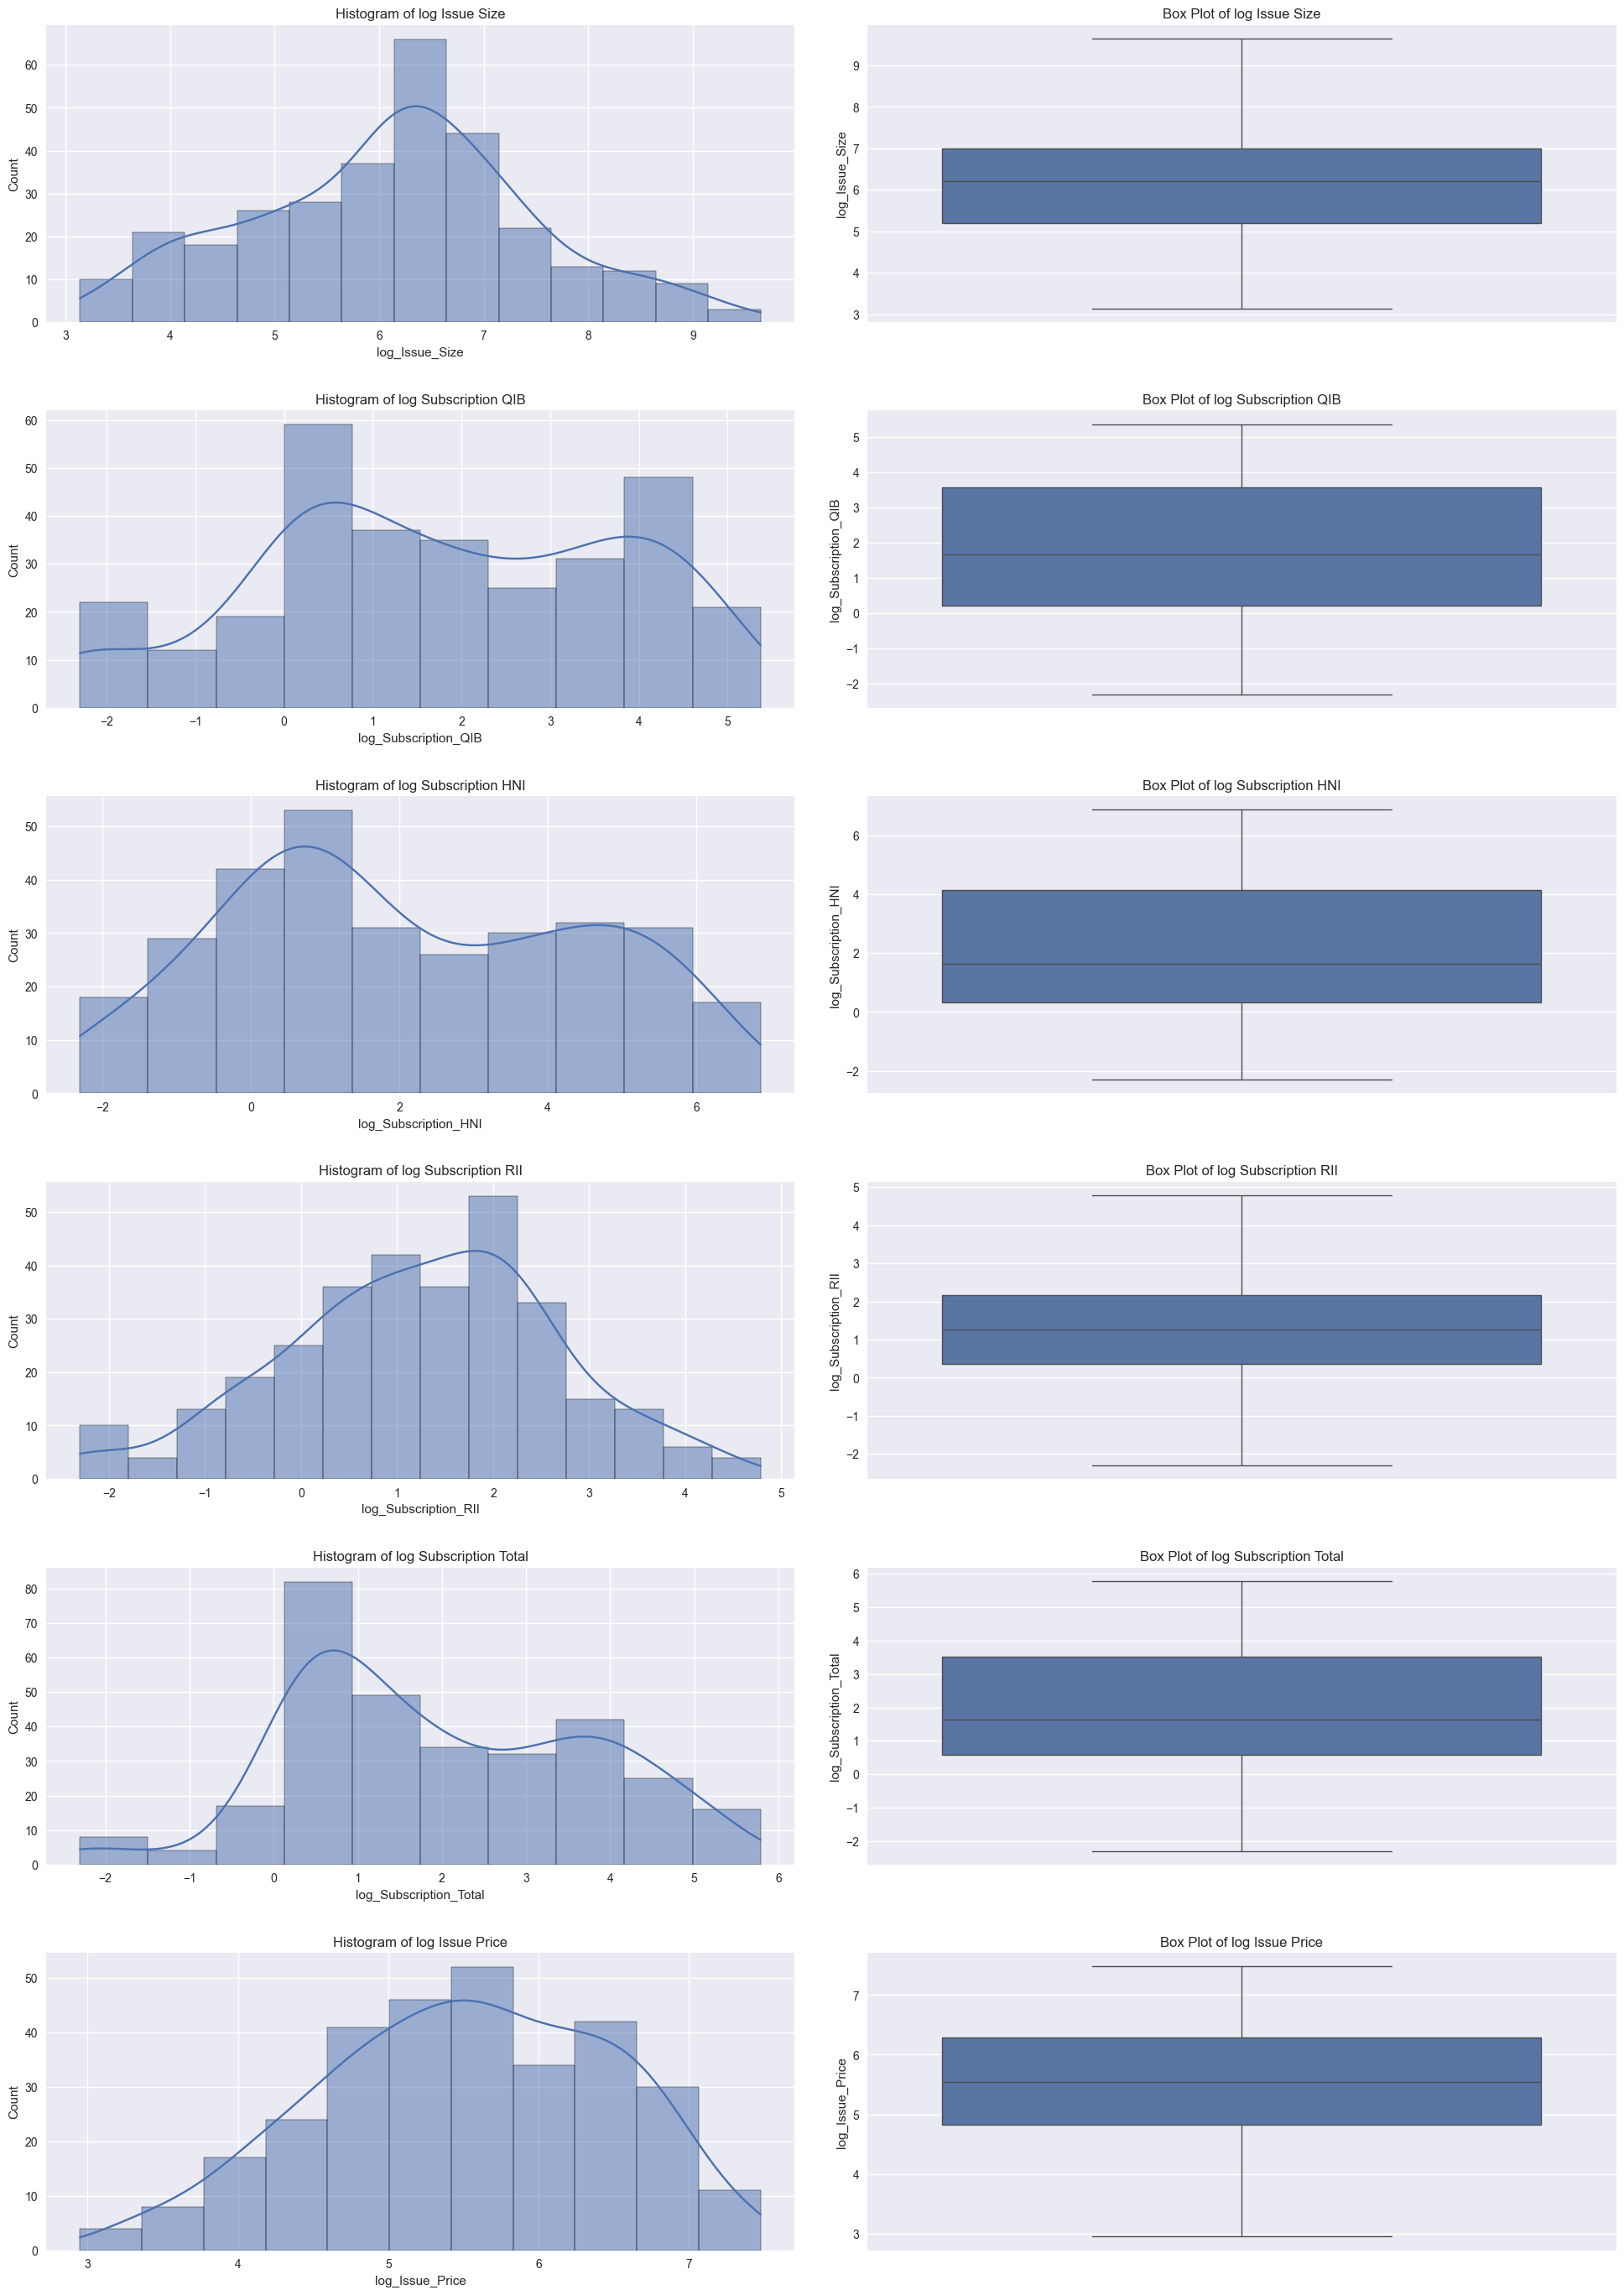


Summary Statistics with Percentiles:


,log_Issue_Size,log_Subscription_QIB,log_Subscription_HNI,log_Subscription_RII,log_Subscription_Total,log_Issue_Price
count,309.000,309.000,309.000,309.000,309.000,309.000
mean,6.120,1.750,2.100,1.240,1.970,5.510
std,1.350,2.040,2.390,1.440,1.760,0.960
min,3.140,-2.300,-2.300,-2.300,-2.300,2.950
5%,3.890,-2.300,-1.640,-1.080,-0.210,3.850
25%,5.200,0.220,0.340,0.350,0.590,4.830
50%,6.210,1.680,1.640,1.270,1.650,5.550
75%,7.000,3.580,4.130,2.170,3.510,6.290
95%,8.510,4.730,5.970,3.660,4.990,6.940
max,9.650,5.370,6.870,4.780,5.790,7.480



Mode(s) of each feature:


,log_Issue_Size,log_Subscription_QIB,log_Subscription_HNI,log_Subscription_RII,log_Subscription_Total,log_Issue_Price
0,6.397,-2.303,-2.303,-2.303,-2.303,4.701
1,NaN,NaN,-1.139,NaN,NaN,5.165



Skewness of each variable:


log_Issue_Size            0.010
log_Subscription_QIB     -0.170
log_Subscription_HNI      0.140
log_Subscription_RII     -0.220
log_Subscription_Total    0.110
log_Issue_Price          -0.230
dtype: float64

In [76]:
explore_features_skewness(data, log_feature_names)

## Creating the Holdout Validation Approach <a name="holdout_validation"></a>

Now it's time to split the data into training and test sets.

The features I'll use for the model are the log-transformed three subscription indices (`log_Subscription_QIB`, `log_Subscription_HNI`, `log_Subscription_RII`).\
`log_Subscription_Total` is a linear combination of the three indices, so it won't bring additional information to the model; `Issue_price` and `Issue_Size` have weaker relationships with the target variable (relatively high p-value), so they may introduce more noise than signal.

I'll create a train/test split, keeping 20% of the data as the test set and stratifying the sets according to the target variable, to make sure the loss/profit ratio is identical among all sets.

In [77]:
X = data[['log_Subscription_QIB', 'log_Subscription_HNI', 'log_Subscription_RII']]
y = data['Listing_Gains_Profit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

print("Training set values:")
display(y_train.value_counts())
print("\nTest set values:")
display(y_test.value_counts())

Training set values:


Listing_Gains_Profit
1    137
0    110
Name: count, dtype: int64


Test set values:


Listing_Gains_Profit
1    34
0    28
Name: count, dtype: int64

## Defining the Deep Learning Classification Model  <a name="define_classification_model"></a>

Now I have everything prepared to build the model. The model I'll use is a neural network; I'll use hyperparameter tuning to find the model that best suits the data I have.

I'll use the `keras_tuner` to create a search grid using Bayesian optimization to find the hyperparameters that will build a model with the highest accuracy.

In [28]:
# Set random seeds for reproducibility
def set_seeds(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Set TensorFlow session-level seed
    tf.keras.utils.set_random_seed(seed)
    # Enable deterministic operations
    tf.config.experimental.enable_op_determinism()

In [29]:
def create_model(hp):
    """
    Creates a neural network model with specified architecture and reduced randomness.
    
    Parameters
    ----------
    hp : keras_tuner.HyperParameters
        Hyperparameter object from Keras Tuner
        
    Returns
    -------
    model : Sequential
        Compiled Keras model
    """

    # Set seeds before model creation
    set_seeds()

    model = Sequential()
    
    # Setting the hyperparameter values
    activation = "relu"
    dropout = hp.Boolean('dropout')
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.1, sampling='linear', parent_name="dropout", parent_values=[True])
    neurons = hp.Int('neurons', min_value=8, max_value=64, step=2, sampling='log')
    learning_rate = hp.Float('learning_rate', min_value = 0.001, max_value = 0.1, step=10, sampling='log')
    hidden_layers = hp.Int('hidden_layers', min_value=2, max_value=4)

    # Input layer with explicit input shape and dtype
    model.add(layers.InputLayer(shape=(3,), activation = activation, dtype=tf.float32))
    
    # Hidden layers
    neurons_in_layer = neurons
    for _ in range(hidden_layers):
        
        model.add(layers.Dense(neurons, activation=activation))
        if dropout:
            model.add(layers.Dropout(dropout_rate, seed=10))
        neurons_in_layer = max(neurons_in_layer // 2, 1)
    
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

In [30]:
def tune_model(X_train, y_train):
    """
    Perform hyperparameter tuning using RandomizedSearchCV.
    
    Parameters
    ----------
    X_train : numpy array
        Training features
    y_train : numpy array
        Training target
        
    Returns
    -------
    tuner : keras_tuner.src.tuners.bayesian.BayesianOptimization
        Tuned models using BayesianOptimization tuning with Gaussian process
    """

    # create the tuner
    tuner = keras_tuner.BayesianOptimization(
        hypermodel=create_model,
        objective="accuracy",
        max_trials=100,
        executions_per_trial=1,
        overwrite=True,
        directory="search_results",
        project_name="hptuner",
        seed=10
    )

    # Perform the search. Max number of epochs is 100, but it's set to stop after hitting the same accuracy 5 times
    tuner.search(X_train, y_train, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping('accuracy', patience=5)])
    
    return tuner

In [48]:
# Run the full pipeline
def run_pipeline(X_train, y_train):
    """
    Run the complete modelling pipeline.
    
    Parameters
    ----------
    X_train   : pandas.DataFrame
        Input training set
    y_train   : pandas.DataFrame
        Input training target
        
    Returns
    -------
    dict
        Dictionary containing top models, their respective hps, the best model and the best hp
    """

    # Tune model
    tuner = tune_model(X_train, y_train)

    # Number of models to return
    num_models = 10
    
    # Print the search space summary
    tuner.search_space_summary(extended=True)
    # Print the results summary
    print("\n")
    tuner.results_summary(num_models)

    # Create the dict to return
    models = tuner.get_best_models(num_models)
    models_hp = tuner.get_best_hyperparameters(num_models)    
    best_model = models[0]
    best_hp = models_hp[0]
    
    return {
        'models' : models,
        'models_hp' : models_hp,
        'best_model': best_model,
        'best_hp': best_hp
    }

Good; both sets have kept the 45/44 loss/profit ratio of the original dataset.

In [41]:
results = run_pipeline(X_train, y_train)

Trial 100 Complete [00h 00m 06s]
accuracy: 0.7327935099601746

Best accuracy So Far: 0.8056679964065552
Total elapsed time: 00h 08m 59s
Search space summary
Default search space size: 5
dropout (Boolean)
{'default': False, 'conditions': []}
dropout_rate (Float)
{'default': 0.2, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'dropout', 'values': [True]}}], 'min_value': 0.2, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
neurons (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 2, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': 10, 'sampling': 'log'}
hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}


Results summary
Results in search_results\hptuner
Showing 10 best trials
Objective(name="accuracy", direction="max")

Trial 018 summary
Hyperparameters:
dropout: False
neurons: 32
learning_rate: 

C:\Users\idany\OneDrive\Documents\Dataquest\envs\tf\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\idany\OneDrive\Documents\Dataquest\envs\tf\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### Retraining the model <a name="retraining_the_model"></a>

I'll take the hyperparameters of the top 10 models (judged by their accuracy), use their hyperparameters to recreate the models, then use the newly created models to evaluate the training and the test datasets, to get their respective scores.

In [43]:
scores = []
for i in range(10):
    hp = results['models_hp'][i]
    model = create_model(hp)
    model.fit(x=X_train, y=y_train, epochs=100, verbose=0, callbacks=[tf.keras.callbacks.EarlyStopping('accuracy', patience=5)])

    # Evaluate on the training data
    train_score = model.evaluate(X_train, y_train)
    print(train_score)
    
    # Evaluate on the test data
    test_score = model.evaluate(X_test, y_test)
    print(test_score)

    scores.append({'train_score': train_score, 'test_score': test_score})


for i in range(10):
    print(f"\nModel {i + 1}:")
    print(f"Training set accuracy: {scores[i]['train_score'][1]}")
    print(f"Test set accuracy: {scores[i]['test_score'][1]}")
    
best_training_model = max(scores, key = lambda x: x['train_score'][1])
best_test_model = max(scores, key = lambda x: x['test_score'][1])
print(f"Best training model: {best_training_model}")
print(f"Best test model: {best_test_model}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8278 - loss: 0.4235  
[0.438006728887558, 0.8016194105148315]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5847 - loss: 0.7128
[0.7841114401817322, 0.5645161271095276]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8278 - loss: 0.4235  
[0.438006728887558, 0.8016194105148315]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5847 - loss: 0.7128
[0.7841114401817322, 0.5645161271095276]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8278 - loss: 0.4235  
[0.438006728887558, 0.8016194105148315]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5847 - loss: 0.7128
[0.7841114401817322, 0.5645161271095276]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8278 - loss: 0.4235  
[0.438006728887558, 0.8016194105148315]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5847 - loss: 0.7128
[0.7841114401817322, 0.5645161271095276]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8278 - loss: 0.4235  
[0.438006728887558, 0.8

### Choosing the Best Model <a name="choosing_the_best_model"></a>

The keras tuner returned the 10 models with the highest accuracy, out of the 100 it generated.\
I'll use each of them to evaluate the training and test datasets, to find a model which behaves well on both sets.

In [42]:
def print_model_values(scores, i):
    '''
    Helper function to print a model's number and scores

    Parameters
    ----------
    scores : list
        Input scores list
    i      : int
        Input index of model in scores
    '''
    
    print(f"\nModel {i + 1}:")
    print(f"Training set accuracy: {scores[i]['train_score'][1]}")
    print(f"Test set accuracy: {scores[i]['test_score'][1]}")

In [47]:
# Empty list to hold the scores
scores = []

# evaluate each model on both the training data and the test data, and save the scores
for i in range(10):
    hp = results['models_hp'][i]
    model = create_model(hp)
    model.fit(x=X_train, y=y_train, epochs=100, verbose=0, callbacks=[tf.keras.callbacks.EarlyStopping('accuracy', patience=5)])

    # Evaluate using the training data
    train_score = model.evaluate(X_train, y_train)
    print(train_score)
    
    # Evaluate using the test data
    test_score = model.evaluate(X_test, y_test)
    print(test_score)

    scores.append({'train_score': train_score, 'test_score': test_score})


for i in range(10):
    print_model_values(scores, i)

# Find the index of the top 2 models (best score on the training set and best score on the test set)
best_training_model_index = scores.index(max(scores, key = lambda x: x['train_score'][1]))
best_test_model_index = scores.index(max(scores, key = lambda x: x['test_score'][1]))

print("=" * 20)
print(f"Best training model:")
print_model_values(scores, best_training_model_index)
print("=" * 20)
print(f"Best test model:")
print_model_values(scores, best_test_model_index)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8278 - loss: 0.4235  
[0.438006728887558, 0.8016194105148315]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5847 - loss: 0.7128
[0.7841114401817322, 0.5645161271095276]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8278 - loss: 0.4235  
[0.438006728887558, 0.8016194105148315]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5847 - loss: 0.7128
[0.7841114401817322, 0.5645161271095276]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8278 - loss: 0.4235 
[0.438006728887558, 0.8016194105148315]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5847 - loss: 0.7128
[0.7841114401817322, 0.5645161271095276]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8278 - loss: 0.4235 
[0.438006728887558, 0.8016194105148315]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5847 - loss: 0.7128
[0.7841114401817322, 0.5645161271095276]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8278 - loss: 0.4235 
[0.438006728887558, 0.8016

So model 1, which is the model with the highest accuracy on the training set (\~80%) has a low accuracy on the test set (\~56%), which points to an overfitted model.
I'll pick model 7 as my model, since while it doesn't have the best training set scores, it performs consistently on both the training data and the test data (\~72% and \~71%, respectively), which points to it being more robust than the former.

## Conclusion <a name="conclusion"></a>

This research explored the application of deep learning techniques to predict listing gains in the Indian IPO market. The methodology involved extensive data preprocessing, feature engineering, and the implementation of a systematic approach to neural network optimization.
The development process included rigorous data cleaning and filtering, followed by a strategic train-test split to ensure robust model validation. Through comprehensive hyperparameter optimization, I generated and evaluated 100 distinct neural network architectures. The best-performing model achieved a 71% prediction accuracy on the test dataset, falling short of my initial 80% target but establishing a solid foundation for future improvements.
Despite extensive experimentation with various architectures and parameters, this accuracy level appears to represent the current optimal performance given the existing approach and data constraints. This outcome suggests that predicting IPO listing gains is a complex challenge that may require additional methodological refinements.
Several promising avenues for future enhancement have been identified:

1. Algorithmic Optimization

* Exploration of alternative optimization algorithms and loss functions
* Implementation of different architectural approaches to neural network design
* Investigation of ensemble methods to improve prediction stability

2. Performance Metric Refinement

* Evaluation of alternative metrics that might better capture model performance in the context of IPO prediction
* Consider incorporating risk-adjusted performance measures

3. Domain Knowledge Integration

* Collaboration with financial experts to incorporate domain-specific insights
* Refinement of feature selection and engineering based on expert feedback
* Development of hybrid models that combine statistical learning with expert rules

These findings provide valuable insights into the challenges and opportunities in applying machine learning to IPO prediction, setting the stage for continued research and development in this area.